# Heterogenous User Preference Prediction

In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [2]:
import os
from collections import Counter,defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from htmldate import find_date
import swifter
from sklearn import metrics
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import scale
import joblib

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/karthik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Filtering Clusters:
* remove clusters with same centers
* remove clusters with too few documents and too large documents
* remove pure clusters
    * have only conservative or only liberal documents

In [5]:
# do this after asking professor
# df["dates"] = df["url"].swifter.apply(lambda x: find_date(x))

In [6]:
# df.to_csv("/data/3/karthik/preference_prediction/articles_with_dates.csv",index=False)

## 1. General Functions

In [7]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('\n***** func:%r took: %2.4f sec ******' % \
          (f.__name__, te-ts))
        return result
    return wrap

In [47]:
def preprocess_text(text):
    """
    """
    pass

def sample_documents(df):
    """
    """
    df_sample = df.sample(frac=0.2, replace=False, random_state=48)
    boolean = not df["article_id"].is_unique
    print("Duplicate values : %s" %str(boolean))
    return df_sample

def tokenize_sentences(text):
    """
    """
    first_10 = sent_tokenize(text)[:10]
    return first_10

@timing
def load_data(path):
    """
    """
    df = pd.read_csv(path)
    print(df.columns)
    print("Df original shape : %s" %str(df.shape))
    # drop rows with text as nan
    df = df[df['text'].notna()]
    print("Df shape after dropping nan text : %s" %str(df.shape))
    # drop articles that have stance = 0
    df = df[df["source_partisan_score"] != 0]
    print("Df shape after dropping 0 stance articles : %s" %str(df.shape))
    # convert articles of stance -1,+1,-2,+2
    df["binary_ps"] = df["source_partisan_score"].apply(lambda x: 1 if x>=1 else 0)
    
    return df

@timing
def vectorize(texts):
    """
    """
    tfidf_vectorizer = TfidfVectorizer(min_df=30, binary=False, max_df=.7, stop_words='english')
    vectors = tfidf_vectorizer.fit_transform(texts)
    vocab = tfidf_vectorizer.vocabulary_
    print("vocab_size : %s"%str(len(vocab)))
    return vectors,vocab

@timing
def cluster_documents(text_vectors,random_state=24,n_clusters=1000):
    """
    """
    km = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state, n_init=1, max_iter=100, batch_size=1000)
    clusters = km.fit_predict(text_vectors)
    return clusters,km

@timing
def get_cluster_sizes(clusters):
    """
    """
    cluster_sizes = Counter(clusters.labels_)
    return cluster_sizes

def plot_size_dist(cluster_sizes):
    """
    """
    plt.figure(figsize=(20,10))
    plt.bar(cluster_sizes.keys(), cluster_sizes.values(),width=2)
    plt.xlim([0,1000])
    plt.xlabel("Cluster-Number")
    plt.ylim([0,4000])
    plt.ylabel("Documents in Cluster")
    plt.show()


@timing
def run_clustering(path="/data/3/karthik/preference_prediction/articles.csv"):
    """
    """
    df = load_data(path)
    
    df_sample = sample_documents(df)
    
    print("Sampling size : %s" %str(df_sample.shape))
    
    print("Selecting first 10 sentences")
    df_sample["first_10"] = df_sample["text"].apply(lambda x: " ".join(sent_tokenize(x)))
    
    print("Adding title and first 10 sentences")
    df_sample["title_first_10"] = df_sample["title"] + ". " + df_sample["first_10"]
    
    print("Vectorizing text")
    X,vocab = vectorize(df_sample["title_first_10"])
    print("Clustering documents")
    clusters,km = cluster_documents(X)
    
    cluster_sizes = get_cluster_sizes(km)
    
    sil_score = metrics.silhouette_score(X, km.labels_, metric='euclidean')
    
    return df_sample,cluster_sizes,clusters,sil_score,vocab,km,X

@timing
def convert_matrix_tuple_list(matrix_2d):
    """
    """
    bookkeeper = defaultdict(int)
    tup_list = []
    for i in range(matrix_2d.shape[0]):
        for j in range(matrix_2d.shape[1]):
            if i != j and bookkeeper[(i,j)]==0 and bookkeeper[(j,i)]==0:
                tup_list.append((i,j,matrix_2d[i,j]))
                bookkeeper[(i,j)] = 1
                bookkeeper[(j,i)] = 1
    return tup_list

@timing
def filter_clusters(cluster_centers,cluster_sizes,min_filter=30,max_filter=1000):
    """
    """
    clusters_2_filter = []
    for i in range(cluster_centers.shape[0]):
        if cluster_sizes[i]<=min_filter or cluster_sizes[i]>=max_filter:
            clusters_2_filter.append(i)
    
    return clusters_2_filter
    

@timing
def create_cluster_pairwise_selection_results(pairwise_results,cluster_sizes):
    """
    """
    df = pd.DataFrame(pairwise_results,columns=["Cluster 1","Cluster 2","Cosine Distance"])
    df["Cluster 1 Size"] = df["Cluster 1"].apply(lambda x:cluster_sizes[x])
    df["Cluster 2 Size"] = df["Cluster 2"].apply(lambda x:cluster_sizes[x])
    return df

@timing
def cluster2doc(texts,cluster_labels):
    """
    """
    cluster_2_doc = defaultdict(list)
    for index,text in enumerate(texts):
        cluster = cluster_labels[index]
        cluster_2_doc[cluster].append(index)
    return cluster_2_doc


def check_cluster_purity(cluster_id,cluster_2_doc_map,df):
    """
    """
    ps_scores = []
    for doc_index in cluster_2_doc_map[cluster_id]:
        ps_scores.append( df["binary_ps"].iloc[doc_index])
    
    unique,count = np.unique(ps_scores, return_counts=True)
    
    if len(unique)==1:
        return True
    else :
        if count[0] >= purity and count[1] >= purity:
            
            return False
        else:
            return True

@timing
def remove_pure_clusters(cluster_pairs,cluster_2_doc_map,df,purity=100):
    """
    """
    filtered_pairs = []
    for cp in cluster_pairs:
        ps_scores_1 = []
        ps_scores_2 = []
        for doc_index in cluster_2_doc_map[cp[0]]:
            ps_scores_1.append( df["binary_ps"].iloc[doc_index])
        for doc_index in cluster_2_doc_map[cp[1]]:
            ps_scores_2.append( df["binary_ps"].iloc[doc_index])
        
        if len(set(ps_scores_1)) == 1:
            pass
        elif len(set(ps_scores_2))==1:
            pass
        elif len(set(ps_scores_1))==1 and len(set(ps_scores_2))==1:
            pass
        else:
            c1c = Counter(ps_scores_1)
            c2c = Counter(ps_scores_2)
            if c1c[0] >= purity and c1c[1] >= purity and c2c[0] >= purity and c2c[1] >= purity:
                filtered_pairs.append(cp)
    
    return filtered_pairs
            

def create_train_test(cluster_pair,cluster2doc,X_feats,df,user_type="Heterogeneous"):
    """
    Labels are based on conservative when homogenous
    """
    c1 = cluster_pair[0]
    c2 = cluster_pair[1]
    
    x_train = X_feats[cluster2doc[c1]]
    x_test = X_feats[cluster2doc[c2]]
    
    ps_train = df["binary_ps"].values[cluster2doc[c1]]
    ps_test = df["binary_ps"].values[cluster2doc[c2]]
    
    if user_type == "Heterogeneous":
        y_train = ps_train
        y_test = list(map(lambda x: 0.0 if x==1.0 else 1.0,ps_test))
    
    if user_type == "Homogeneous":
        y_train = ps_train
        y_test = ps_test
    
    u_train,c_train = np.unique(y_train, return_counts=True)
    u_test,c_test = np.unique(y_test, return_counts=True)
    print("Train Label Dist :\n %s : %s\n %s:%s" %(str(u_train[0]),str(c_train[0]),str(u_train[1]),str(c_train[1])))
    print("Test Label Dist :\n %s : %s\n %s:%s" %(str(u_test[0]),str(c_test[0]),str(u_test[1]),str(c_test[1])))
    
    assert x_train.shape[0] == len(y_train)
    assert x_test.shape[0] == len(y_test)
    
    return x_train,x_test,y_train,y_test

@timing
def run_cluster_filtering(km,cluster_sizes,min_filter,max_filter,cluster_2_doc_map,dist_threshold=0.2):
    """
    """
    cluster_centers = km.cluster_centers_
    pairwise_dist = cosine_similarity(cluster_centers)
    pairwise_scores_list = convert_matrix_tuple_list(pairwise_dist)
    print("Original no of cluster pairs : %s" %str(len(pairwise_scores_list)))
    
    # filter out clusters with same centers
    filtered_pairwise_scores = list(filter(lambda x: x[2]>0 , pairwise_scores_list))
    print("no of clusters after filtering out clusters with same centers : %s" %str(len(filtered_pairwise_scores)))
    
    # filter out extremely small clusters and large clusters
    clusters_2_remove = filter_clusters(cluster_centers,cluster_sizes,min_filter=500,max_filter=3000)
    filtered_pairwise_scores = list(filter(lambda x: x[0] not in clusters_2_remove and x[1] not in clusters_2_remove,filtered_pairwise_scores))
    print("no of clusters after filtering out too small and too large clusters : %s" %str(len(filtered_pairwise_scores)))

    # remove pure clusters, checks if either of the clusters in a pair are pure
    filtered_pairwise_scores = remove_pure_clusters(filtered_pairwise_scores,cluster_2_doc_map,df,purity=100)
    print("no of clusters after filtering out pure clusters : %s" %str(len(filtered_pairwise_scores)))
    
    # remove clusters that are too similar i.e cosine sim < 0.1 (centers are almost the same)
#     filtered_pairwise_scores = list(filter(lambda x: x[2]>dist_threshold , filtered_pairwise_scores))
#     print("no of clusters after filtering out too similar clusters : %s" %str(len(filtered_pairwise_scores)))
    
    print(np.mean(filtered_pairwise_scores))
    
    top_100_filtered = sorted(filtered_pairwise_scores,key=lambda x:x[2],reverse=True)[:100]
    
    pairwise_results = create_cluster_pairwise_selection_results(top_100_filtered,cluster_sizes)
    
    return pairwise_results
    

def get_scores(y_test,predictions,threshold):
    """
    """
    predicted_probas = predictions[:,1]
    predictions = np.where(predicted_probas>=threshold,1,0).flatten()
    f1 = metrics.f1_score(y_test,predictions,zero_division=0)
    precision = metrics.precision_score(y_test,predictions,zero_division=0)
    recall = metrics.recall_score(y_test,predictions,zero_division=0)
    accuracy = metrics.accuracy_score(y_test,predictions)
    
    return f1,precision,recall,accuracy
    
def run_model(x_train,x_test,y_train,y_test):
    """
    """
    clf = LogisticRegressionCV(cv=5,random_state=0,max_iter=1000,n_jobs=-1).fit(x_train, y_train)
    predicted_probas = clf.predict_proba(x_test)
    print(predicted_probas.shape)
    return clf,predicted_probas

@timing
def plot_sim_vs_score(df_results,threshold):
    """
    """
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
    axes = ax.ravel()
    sim_score = df_results["Cosine Distance"].tolist()
    scores = df_results["threshold - %s"%str(threshold)].tolist()
    f1,precision,recall,accuracy = zip(*scores)
    
    s = 50
    
    axes[0].scatter(sim_score,f1,marker="*",s=s)
    z = np.polyfit(sim_score,f1, 1)
    p = np.poly1d(z)
    axes[0].plot(sim_score,p(sim_score),"r--")
    axes[0].set_xlabel("Cosine Similarity between cluster pairs")
    axes[0].set_ylabel("F1-Score")
    
    axes[1].scatter(sim_score,precision,marker="o",s=s)
    z = np.polyfit(sim_score,precision, 1)
    p = np.poly1d(z)
    axes[1].plot(sim_score,p(sim_score),"r--")
    axes[1].set_xlabel("Cosine Similarity between cluster pairs")
    axes[1].set_ylabel("Precision")
    
    axes[2].scatter(sim_score,recall,marker="^",s=s)
    z = np.polyfit(sim_score,recall, 1)
    p = np.poly1d(z)
    axes[2].plot(sim_score,p(sim_score),"r--")
    axes[2].set_xlabel("Cosine Similarity between cluster pairs")
    axes[2].set_ylabel("Recall")
    
    axes[3].scatter(sim_score,accuracy,marker="+",s=s)
    z = np.polyfit(sim_score,accuracy, 1)
    p = np.poly1d(z)
    axes[3].plot(sim_score,p(sim_score),"r--")
    axes[3].set_xlabel("Cosine Similarity between cluster pairs")
    axes[3].set_ylabel("Accuracy")
    
    fig.suptitle("Cluster Similarity vs Classifier Performance | Threshold : %s" %str(threshold))
    fig.tight_layout()
    
    plt.show()

@timing
def run_train_all(X,cluster_2_doc_map,df,pairwise_results,thresholds = [0.5,0.7,0.9],user_type="Heterogeneous"):
    """
    """
    results = defaultdict(list)
    for index,row in pairwise_results.iterrows():
            print("Training model for cluster pair : %s" %str(index))
            x_train,x_test,y_train,y_test = create_train_test(cluster_pair=(row[0],row[1]),
                                                              cluster2doc=cluster_2_doc_map,
                                                              X_feats=X,
                                                              df=df,
                                                              user_type=user_type)

            clf,predicted_probas = run_model(x_train,x_test,y_train,y_test)

            for t in thresholds:
                f1,precision,recall,accuracy = get_scores(y_test,
                                                          predictions=predicted_probas,
                                                          threshold=t)
                results[t].append((f1,precision,recall,accuracy))
    
    return results

## 2. Clustering

In [48]:
df,cluster_sizes,clusters,sil_score,vocab,km,X = run_clustering()

KeyboardInterrupt: 

In [ ]:
sil_score

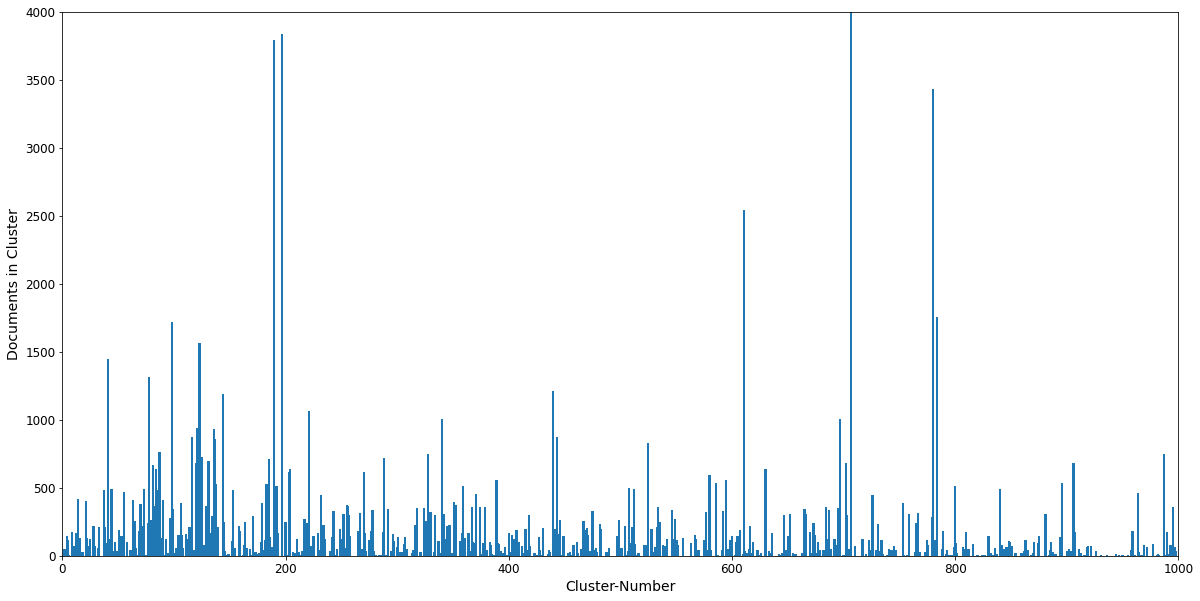

In [13]:
plot_size_dist(cluster_sizes)

## 3. Pairwise Cluster Identification

In [49]:
cluster_2_doc_map = cluster2doc(texts=df["title_first_10"],cluster_labels=km.labels_)


***** func:'cluster2doc' took: 0.1880 sec ******


In [50]:
pairwise_results = run_cluster_filtering(km=km,
                                         cluster_sizes=cluster_sizes,
                                         min_filter=500,
                                         max_filter=3000,
                                         cluster_2_doc_map=cluster_2_doc_map)


***** func:'convert_matrix_tuple_list' took: 0.8628 sec ******
Original no of cluster pairs : 499500
no of clusters after filtering out clusters with same centers : 498077

***** func:'filter_clusters' took: 0.0030 sec ******
no of clusters after filtering out too small and too large clusters : 946

***** func:'remove_pure_clusters' took: 16.6984 sec ******
no of clusters after filtering out pure clusters : 903
238.6926557079935

***** func:'create_cluster_pairwise_selection_results' took: 0.0028 sec ******

***** func:'run_cluster_filtering' took: 20.8990 sec ******


In [64]:
pairwise_results.head(50)

,Cluster 1,Cluster 2,Cosine Distance,Cluster 1 Size,Cluster 2 Size
0,87,192,0.927001,763,516
1,123,784,0.799419,1565,1757
2,123,131,0.787800,1565,701
3,131,784,0.761790,701,1757
4,78,896,0.759672,1312,537
5,125,580,0.721187,727,596
6,78,116,0.652988,1312,876
7,800,906,0.645706,515,682
8,125,987,0.608531,727,749
9,443,784,0.603406,871,1757


## 4. Model Training and Testing

In [52]:
results = run_train_all(X,cluster_2_doc_map,df,pairwise_results,thresholds = [0.5,0.7,0.9],user_type="Heterogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 395
 1:368
Test Label Dist :
 0.0 : 266
 1.0:250
(516, 2)
Training model for cluster pair : 1
Train Label Dist :
 0 : 968
 1:597
Test Label Dist :
 0.0 : 754
 1.0:1003
(1757, 2)
Training model for cluster pair : 2
Train Label Dist :
 0 : 968
 1:597
Test Label Dist :
 0.0 : 291
 1.0:410
(701, 2)
Training model for cluster pair : 3
Train Label Dist :
 0 : 410
 1:291
Test Label Dist :
 0.0 : 754
 1.0:1003
(1757, 2)
Training model for cluster pair : 4
Train Label Dist :
 0 : 684
 1:628
Test Label Dist :
 0.0 : 242
 1.0:295
(537, 2)
Training model for cluster pair : 5
Train Label Dist :
 0 : 448
 1:279
Test Label Dist :
 0.0 : 221
 1.0:375
(596, 2)
Training model for cluster pair : 6
Train Label Dist :
 0 : 684
 1:628
Test Label Dist :
 0.0 : 387
 1.0:489
(876, 2)
Training model for cluster pair : 7
Train Label Dist :
 0 : 368
 1:147
Test Label Dist :
 0.0 : 220
 1.0:462
(682, 2)
Training model for cluster pair : 8
Train Label Dist

In [53]:
df_results = pairwise_results.copy()
for k in results:
    df_results["threshold - %s"%str(k)] = results[k]

In [54]:
joblib.dump(df_results,"Results_df.joblib")

['Results_df.joblib']

## 5. Results and Analysis

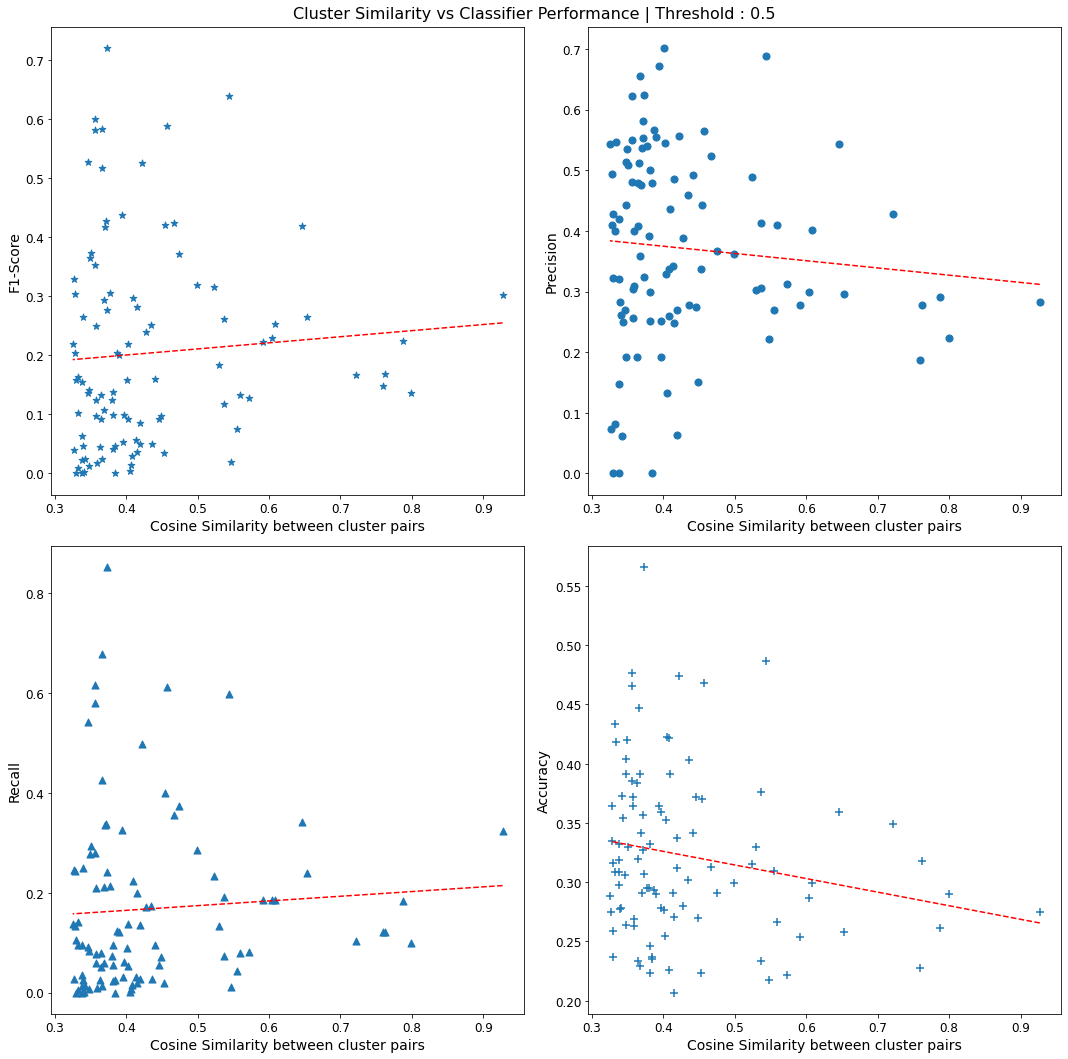


***** func:'plot_sim_vs_score' took: 0.6006 sec ******


In [55]:
plot_sim_vs_score(df_results,threshold=0.5)

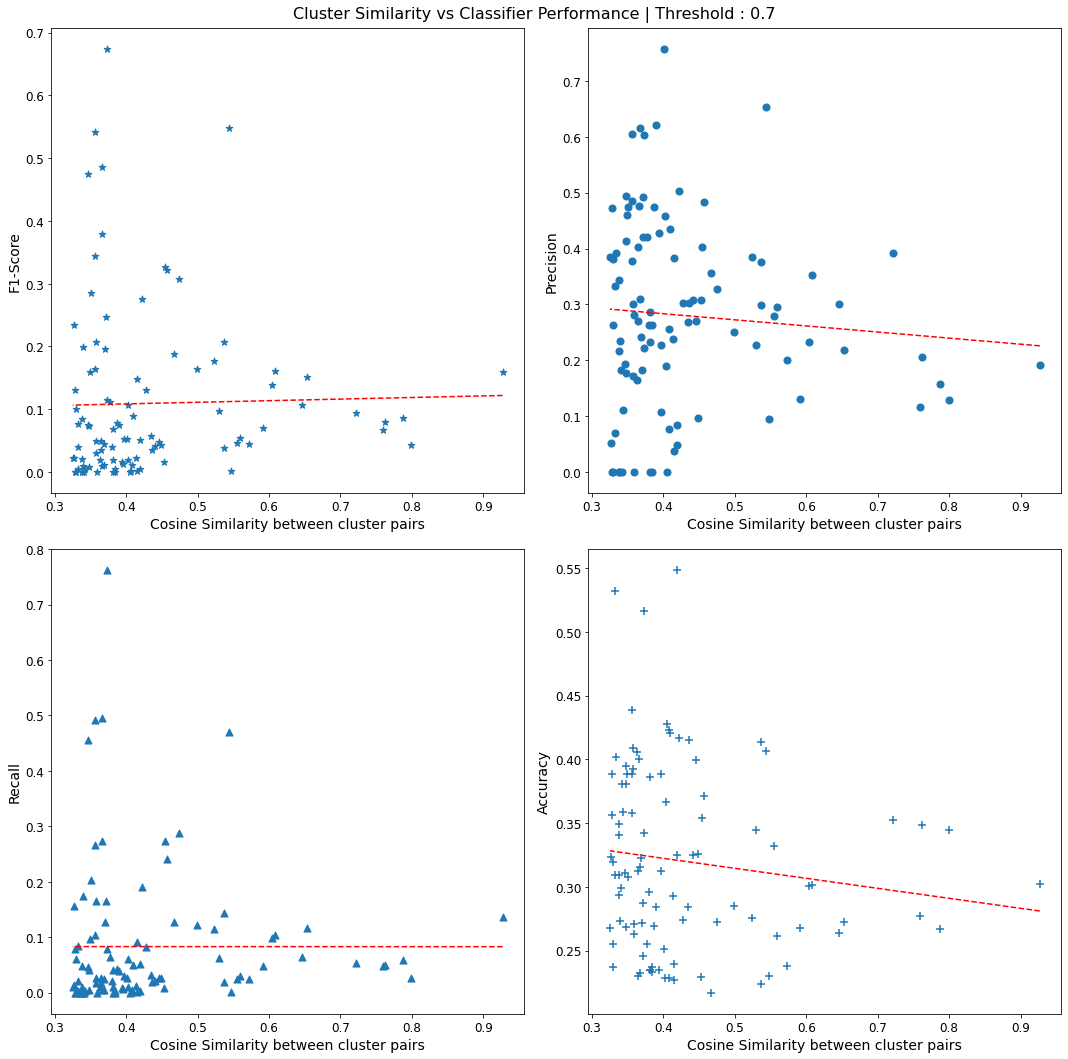


***** func:'plot_sim_vs_score' took: 0.6016 sec ******


In [56]:
plot_sim_vs_score(df_results,threshold=0.7)

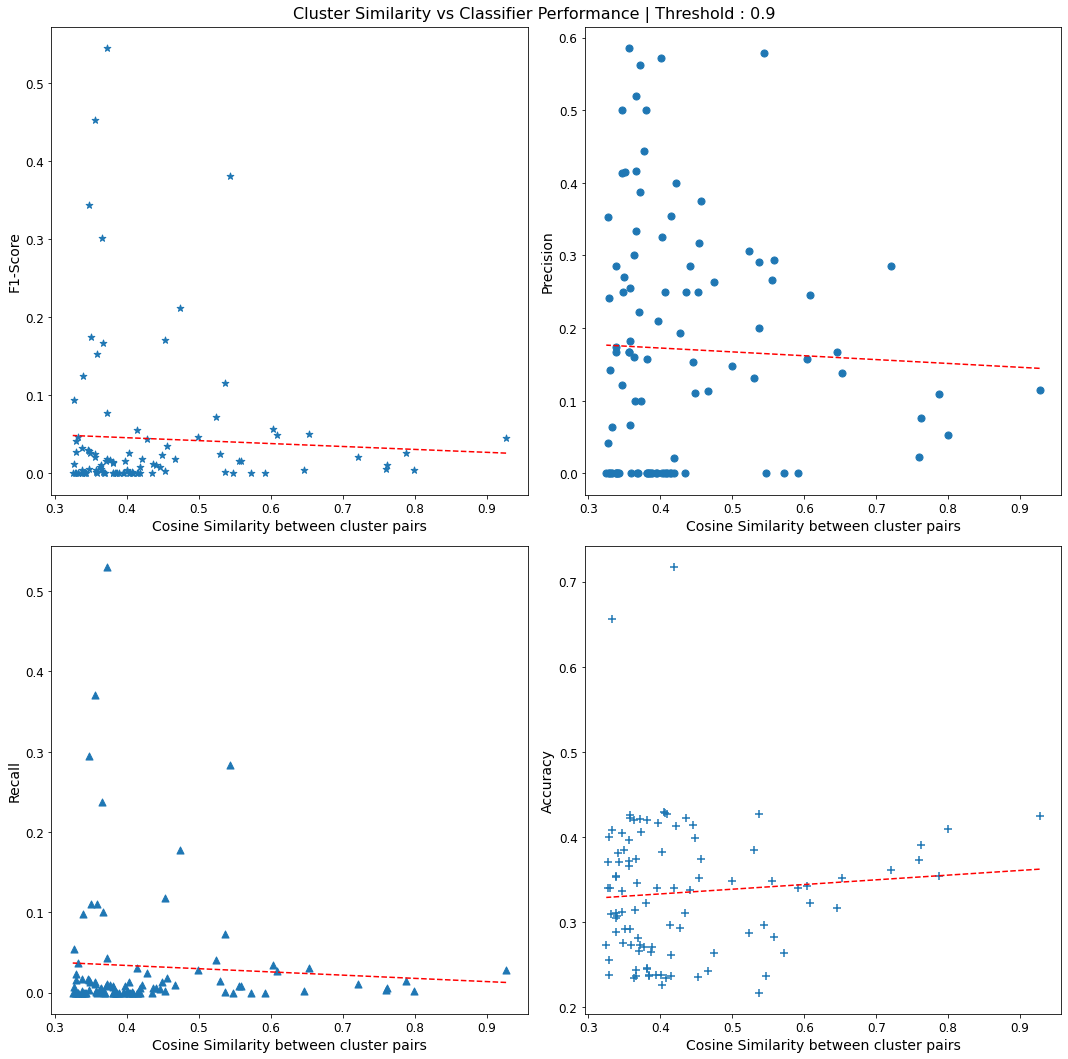


***** func:'plot_sim_vs_score' took: 0.5721 sec ******


In [57]:
plot_sim_vs_score(df_results,threshold=0.9)

## Homogeneous User Results

In [58]:
results_homogeneous = run_train_all(X,cluster_2_doc_map,df,pairwise_results,thresholds = [0.5,0.7,0.9],user_type="Homogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 395
 1:368
Test Label Dist :
 0 : 250
 1:266
(516, 2)
Training model for cluster pair : 1
Train Label Dist :
 0 : 968
 1:597
Test Label Dist :
 0 : 1003
 1:754
(1757, 2)
Training model for cluster pair : 2
Train Label Dist :
 0 : 968
 1:597
Test Label Dist :
 0 : 410
 1:291
(701, 2)
Training model for cluster pair : 3
Train Label Dist :
 0 : 410
 1:291
Test Label Dist :
 0 : 1003
 1:754
(1757, 2)
Training model for cluster pair : 4
Train Label Dist :
 0 : 684
 1:628
Test Label Dist :
 0 : 295
 1:242
(537, 2)
Training model for cluster pair : 5
Train Label Dist :
 0 : 448
 1:279
Test Label Dist :
 0 : 375
 1:221
(596, 2)
Training model for cluster pair : 6
Train Label Dist :
 0 : 684
 1:628
Test Label Dist :
 0 : 489
 1:387
(876, 2)
Training model for cluster pair : 7
Train Label Dist :
 0 : 368
 1:147
Test Label Dist :
 0 : 462
 1:220
(682, 2)
Training model for cluster pair : 8
Train Label Dist :
 0 : 448
 1:279
Test Label Di

In [59]:
df_results = pairwise_results.copy()
for k in results_homogeneous:
    df_results["threshold - %s"%str(k)] = results_homogeneous[k]

In [60]:
joblib.dump(df_results,"Results_df_homogeneous.joblib")

['Results_df_homogeneous.joblib']

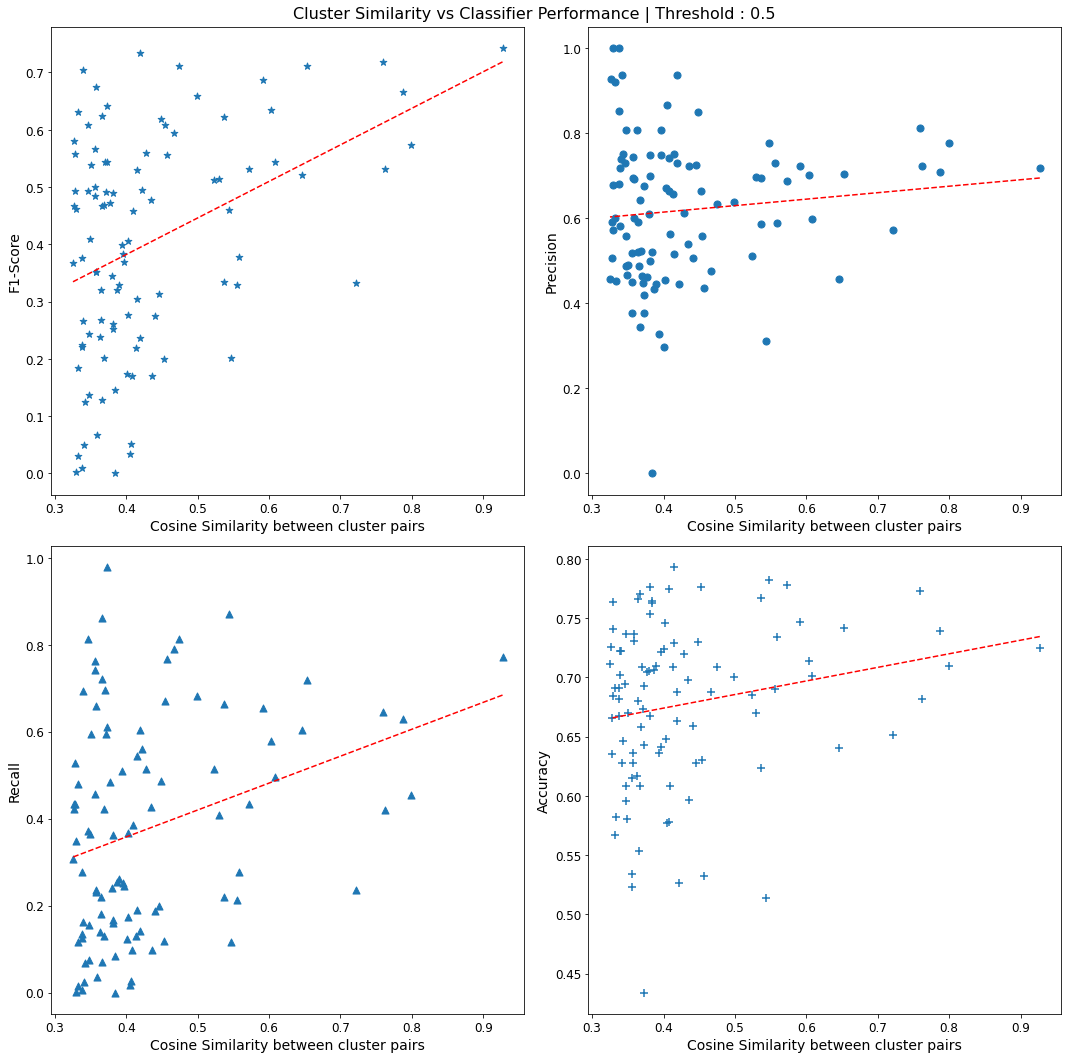


***** func:'plot_sim_vs_score' took: 0.6006 sec ******


In [61]:
plot_sim_vs_score(df_results,threshold=0.5)

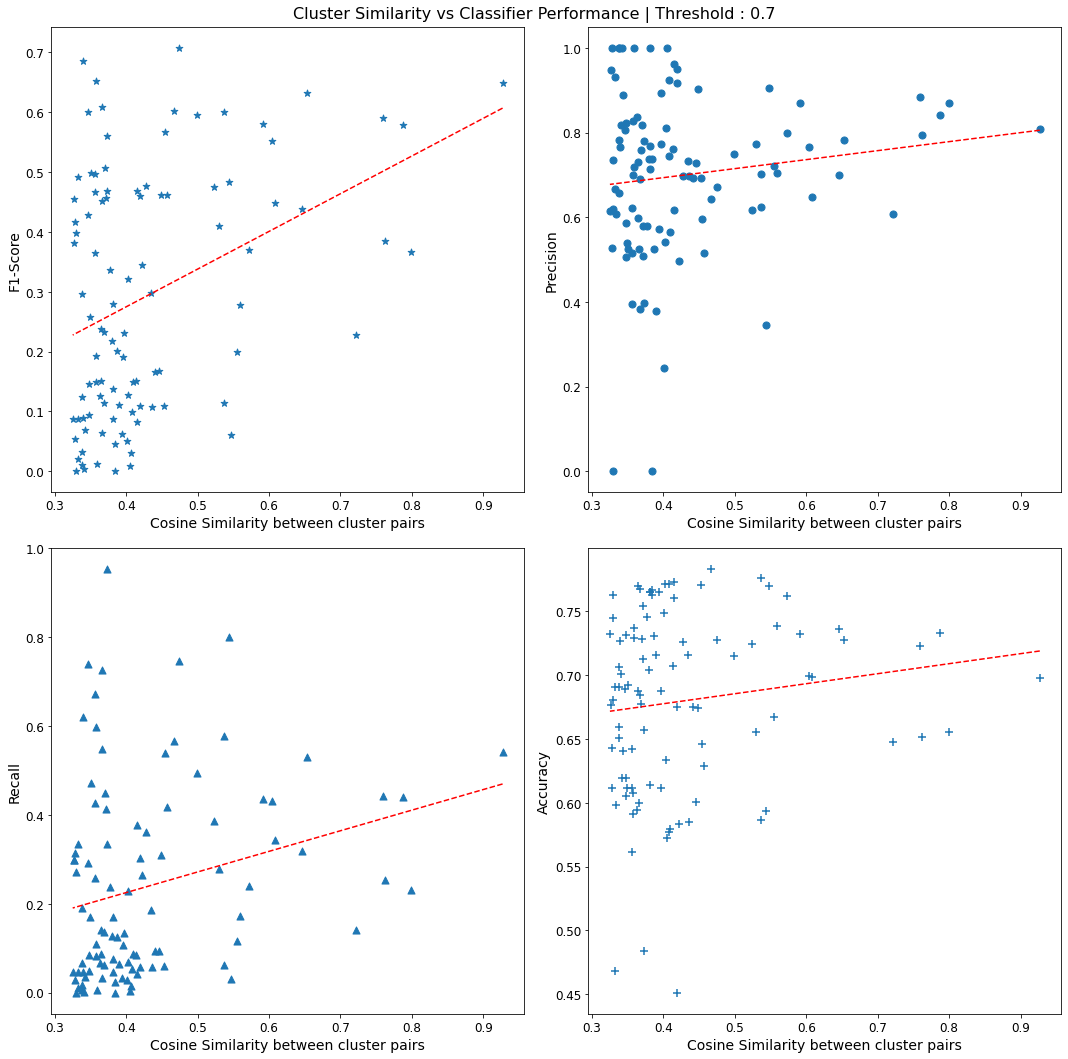


***** func:'plot_sim_vs_score' took: 0.5977 sec ******


In [62]:
plot_sim_vs_score(df_results,threshold=0.7)

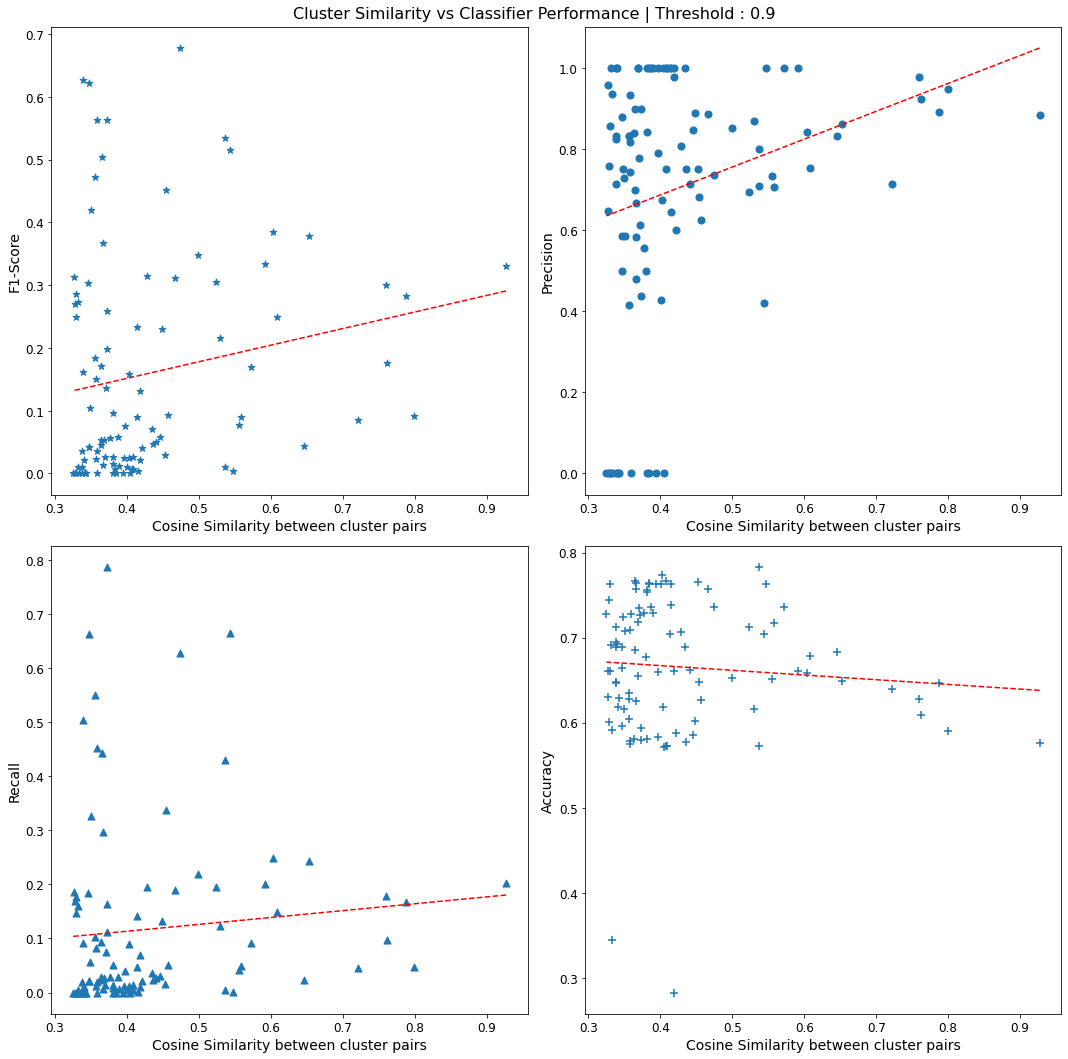


***** func:'plot_sim_vs_score' took: 0.5943 sec ******


In [63]:
plot_sim_vs_score(df_results,threshold=0.9)